In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)
from pandas import json_normalize
import numpy as np
import os
import csv
import multiprocessing as mp
import re
from datetime import datetime
# import helper as h
# import AQDataHelper as aqh
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib
import geopy


import warnings
warnings.filterwarnings("ignore")


In [2]:
df_articles = pd.read_csv("../dataset/News_articles_dataset/News_articles_dataset.csv.gz")
df_articles

,media,date,url,heading,content,other.author,other.top_image,other.category,city,year,state,district,matches
0,TOI,2010-01-01,http://timesofindia.indiatimes.com//city/mumbai/Mumbai-celebrates-a-cool-New-Years-Eve-at-13-4C/...,Mumbai celebrates a cool New Year's Eve at 13.4फ्C,MUMBAI: The city witnessed its lowest temperature of the season on New Year ’s Eve when the merc...,"TNN / Jan 1, 2010, 01:47 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,mumbai,2010.0,maharashtra,mumbai suburban,{'smog': 3.0}
1,TOI,2010-01-02,http://timesofindia.indiatimes.com//city/lucknow/Dense-fog-leads-to-tripping-of-power-lines/arti...,Dense fog leads to tripping of power lines,LUCKNOW: The UP Power Corporation Limited is keeping its fingers crossed for Saturday with the s...,"TNN / Jan 2, 2010, 06:40 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,lucknow,2010.0,uttar pradesh,lucknow,{'air pollutants': 2.0}
2,TOI,2010-01-09,http://timesofindia.indiatimes.com//city/chennai/City-has-high-levels-of-smog-forming-ozone/arti...,City has high levels of smog-forming ozone,CHENNAI: Dangerous levels of ground-level ozone that causes respiratory ailments could be envelo...,"Bhama Devi Ravi / TNN / Jan 9, 2010, 00:37 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,chennai,2010.0,tamil nadu,chennai,"{'ozone': 9.0, 'smog': 4.0}"
3,TOI,2010-01-11,http://timesofindia.indiatimes.com//city/jaipur/Woman-four-kids-in-hospital-after-inhaling-smoke...,"Woman, four kids in hospital after inhaling smoke",JAIPUR: A woman and her four kids were admitted to a city hospital in a serious condition after ...,"TNN / Jan 11, 2010, 01:56 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,jaipur,2010.0,rajasthan,jaipur,{'carbon monoxide': 1.0}
4,TOI,2010-01-13,http://timesofindia.indiatimes.com//city/chennai/Pollution-high-on-Bhogi-eve-Study/articleshow/5...,Pollution high on Bhogi eve: Study,"CHENNAI: By the time you get to read this, the Bhogi pollutants may have enveloped the city, but...","Bhama Devi Ravi / TNN / Jan 13, 2010, 04:23 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75...",NaN,chennai,2010.0,tamil nadu,chennai,"{'air quality': 1.0, 'carbon monoxide': 1.0, 'ozone': 1.0, 'so2': 1.0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17369,Hindu,2021-05-16,https://www.thehindu.com/news/national/andhra-pradesh/naval-dockyard-teams-repair-two-oxygen-pla...,Naval Dockyard teams repair two oxygen plants in Nellore and Srikalahasti,Oxygen supply gets a big boost with this in the State during the pandemic\n\nTeams from the Nava...,SpecialCorrespondent,https://www.thehindu.com/news/national/andhra-pradesh/fvjzld/article34572702.ece/ALTERNATES/LAND...,andhra pradesh,visakhapatnam,NaN,andhra pradesh,visakhapatnam,{'carbon monoxide': 2.0}
17370,Hindu,2021-05-24,https://www.thehindu.com/news/national/kerala/greens-call-for-a-relook-into-silverline-implement...,Greens call for a relook into SilverLine implementation,"The Kerala Paristhithi Aikya Vedi, a forum of environmentalists, has urged Chief Minister Pinara...",SpecialCorrespondent,https://www.thehindu.com/static/theme/default/base/img/og-image.jpg,kerala,thiruvananthapuram,NaN,kerala,thiruvananthapuram,{'air pollution': 1.0}
17371,Hindu,2021-05-25,https://www.thehindu.com/news/national/karnataka/cftris-ozone-based-air-disinfection-system-to-c...,CFTRI’s ozone-based air disinfection system to combat droplet infections,The CSIR-Central Food Technological Research Institute (CFTRI) in Mysuru has come up with an ozo...,LaiqhAKhan,https://www.thehindu.com/sci-tech/science/wsmdd0/article33283019.ece/ALTERNATES/LANDSCAPE_615/CF...,karnataka,mysuru,NaN,karnataka,mysuru,{'ozone': 9.0}
17372,Hindu,2021-05-28,https://www.thehindu

In [3]:
#load PM2.5 data 2010-2019 (cpcb)
root_path = "../PMdataset/"
df_daily_city_stn = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_station_2010_19.csv",index_col=0)
df_daily_city = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_2010_19.csv",index_col=0)
df_daily_city

,Unnamed: 0.1,From Date,city,WS,WD,Gust,Variance,AT,RH,SR,BP,PPAccum,Power,PM10,PM2_5,NO,NO2,NOx,CO,CO2,Ozone,BlackCarbon,Benzene,Toluene,Eth-Benzene,Xylene,CH4,NMHC,VWS,THC,NH3,SO2,Temp,MP-Xylene,RF,RackTemp,P_Xylene,O Xylene,ETH,SPM,AP,MH,readings_in_day,total_stations,active_stations,state
0,0,2010-01-01,Agra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Uttar Pradesh
1,1,2010-01-01,Ahmedabad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Gujarat
2,2,2010-01-01,Ambala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Haryana
3,3,2010-01-01,Ankleshwar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Gujarat
4,4,2010-01-01,Bahadurgarh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,Haryana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202192,202192,2019-04-30,Udaipur,1.017579,253.649263,NaN,NaN,NaN,17.871263,192.898000,757.183158,NaN,NaN,87.814737,34.304255,13.917158,19.854526,33.771684,0.734835,NaN,38.070213,NaN,1.563936,NaN,4.092842,NaN,NaN,NaN,NaN,NaN,12.120947,12.064725,33.071053,1.188842,0.0,NaN,NaN,3.700211,NaN,NaN,NaN,NaN,94.0,1,1,Rajasthan
202193,202193,2019-04-30,Ujjain,4.636842,255.042105,NaN,NaN,36.660000,18.252632,161.242105,NaN,NaN,NaN,147.452632,40.126316,NaN,8.891011,5.250562,0.819535,NaN,78.206522,NaN,0.000000,0.620000,0.000000,NaN,NaN,NaN,NaN,NaN,19.031461,8.647059,31.801075,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,1,1,Madhya Pradesh
202194,202194,2019-04-30,Varanasi,0.801053,180.757895,NaN,NaN,33.582105,23.600000,80.157895,745.378947,NaN,NaN,331.126761,131.732394,51.202360,104.323370,74.652174,0.860652,NaN,76.047692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.522105,NaN,NaN,37.748652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,1,1,Uttar Pradesh
202195,202195,2019-04-30,Vijayawada,0.519041,221.018904,NaN,NaN,37.019178,55.307671,228.706154,749.476301,NaN,NaN,50.119577,20.220000,6.365139,14.738356,21.004658,NaN,NaN,NaN,NaN,0.996849,1.870137,0.057397,NaN,NaN,NaN,5.000000,NaN,5.329589,6.234658,NaN,0.734110,0.0,NaN,NaN,1.899589,NaN,NaN,NaN,NaN,67.0,1,1,Andhra Pradesh


In [4]:
#load OpenAQ data 2019-2021
root_path = "../PMdataset/"
df_daily_city_stn_oq = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_station_2019_21_openaq.csv",index_col=0)
df_daily_city_oq = pd.read_csv(root_path+"pm2.5_allcities_groupby_date_city_2019_21_openaq.csv",index_col=0)
df_daily_city_oq

,From Date,city,PM2_5,readings,total_stations,active_stations
0,2019-01-18,Delhi,133.960000,2.0,1,1
2,2019-04-30,Agra,90.000000,1.0,1,1
3,2019-04-30,Ajmer,105.640000,2.0,1,1
4,2019-04-30,Amaravati,22.000000,1.0,1,1
6,2019-04-30,Amritsar,50.970000,1.0,1,1
...,...,...,...,...,...,...
75127,2021-08-01,Solapur,18.020000,69.0,1,1
75128,2021-12-03,Solapur,NaN,0.0,1,0
75129,2021-12-04,Solapur,NaN,0.0,1,0
75130,2021-12-05,Solapur,14.172069,29.0,1,1


In [5]:
#merge cpcb and openaq 
df_daily_city_merged = pd.concat([df_daily_city,df_daily_city_oq])[["From Date","city",
                                                                    "PM2_5","total_stations","active_stations","state"]]

df_daily_city_merged.city = df_daily_city_merged.city.apply(lambda x:x.strip().lower())
df_daily_city_merged["From Date"] = pd.to_datetime(df_daily_city_merged["From Date"])
df_daily_city_merged

,From Date,city,PM2_5,total_stations,active_stations,state
0,2010-01-01,agra,NaN,1,0,Uttar Pradesh
1,2010-01-01,ahmedabad,NaN,1,0,Gujarat
2,2010-01-01,ambala,NaN,1,0,Haryana
3,2010-01-01,ankleshwar,NaN,1,0,Gujarat
4,2010-01-01,bahadurgarh,NaN,1,0,Haryana
...,...,...,...,...,...,...
75127,2021-08-01,solapur,18.020000,1,1,NaN
75128,2021-12-03,solapur,NaN,1,0,NaN
75129,2021-12-04,solapur,NaN,1,0,NaN
75130,2021-12-05,solapur,14.172069,1,1,NaN


In [6]:
df_daily_city_merged.state.unique()

array(['Uttar Pradesh', 'Gujarat', 'Haryana', 'Karnataka', 'Tamil Nadu',
       'Madhya Pradesh', 'Delhi', 'Assam', 'Telangana', 'Maharashtra',
       'Bihar', 'West Bengal', 'Rajasthan', 'Andhra Pradesh', 'Punjab',
       'Odisha', 'Jharkhand', 'Kerala', nan], dtype=object)

# create table for PM2.5 & articles for cities

In [7]:
#check city wise data start date & end date
def get_start_date(city,threshold = 0.8,n = 365):
    print(city)
    test = df_daily_city_merged[df_daily_city_merged.city == city]
    test["From Date"] = pd.to_datetime(test["From Date"])
    test_drop_na = test.dropna(subset=["PM2_5"])

    for idx,row in test_drop_na.iterrows():
        curr_date = row["From Date"]
        n = 365
        end_date = curr_date+pd.Timedelta(days=n)
        date_range = pd.date_range(curr_date,end_date)
        temp = test[test["From Date"].isin(date_range)]
        frac = len(temp.dropna(subset=["PM2_5"]))/len(temp)
        #print(frac)
        threshold = 0.8
        if frac >threshold:
            print(curr_date)
            return curr_date
def get_unique_cities_from_df(df,col="city"):
    '''
    returns dataframe of city->articles from dataframe
    as city can be list so unique() will not work
    '''
    unq = {}
    for each in df[col].values:
        if type(each) == str:
            cities = [each]
        elif type(each) == list:
            cities = each
        else:
            continue
        for city in cities:
            try:
                unq[city]+=1
            except:
                unq[city] = 1
    df = pd.DataFrame(unq.items(),columns = ["city","articles"]).sort_values("articles",ascending=False)
    return df

In [8]:
cdf = get_unique_cities_from_df(df_articles)
igp_cities = ["delhi","agra","lucknow","patna","kanpur","varanasi","noida","gurugram","faridabad","kolkata","amritsar"]
most_discussed_cities = list(cdf.nlargest(11,"articles")["city"].values) #most 11 discussed cities in news-media
needed_cities = list(set(igp_cities + most_discussed_cities)) #most
print(len(needed_cities),needed_cities)




#needed_cities = h.get_unique_cities_from_df(df_articles).nlargest(15,"articles")["city"].values

start_date = datetime(2010,1,1)
end_date = datetime(2021,6,1)

#df_cross_cities = df_daily_city_merged[(df_daily_city_merged["From Date"] >= start_date) & (df_daily_city_merged["From Date"] <= end_date)]
df_cross_cities = df_daily_city_merged.copy()
df_cross_cities = df_cross_cities[df_cross_cities.city.isin(needed_cities)]
dfs = []
for city in needed_cities:
    try:
        start_date = get_start_date(city)
        df = df_cross_cities[(df_cross_cities["city"] == city) & (df_cross_cities["From Date"]>start_date)]
        dfs.append(df)
    except Exception as e:
        print(city,e)
    
df_cross_cities = pd.concat(dfs)
df_cross_cities = pd.crosstab(index=df_cross_cities["From Date"],
                              columns=df_cross_cities.city,values=df_cross_cities["PM2_5"],aggfunc=lambda x:x)
df_cross_cities

18 ['mumbai', 'lucknow', 'delhi', 'noida', 'kanpur', 'bengaluru', 'varanasi', 'faridabad', 'hyderabad', 'chandigarh', 'amritsar', 'patna', 'chennai', 'nagpur', 'pune', 'kolkata', 'gurugram', 'agra']
mumbai
2014-09-05 00:00:00
lucknow
2015-03-18 00:00:00
delhi
2010-02-17 00:00:00
noida
2017-07-17 00:00:00
kanpur
2015-05-12 00:00:00
bengaluru
2015-03-20 00:00:00
varanasi
2014-09-13 00:00:00
faridabad
2015-05-20 00:00:00
hyderabad
2015-03-31 00:00:00
chandigarh
chandigarh Invalid comparison between dtype=datetime64[ns] and NoneType
amritsar
2017-02-27 00:00:00
patna
2015-10-01 00:00:00
chennai
2015-03-23 00:00:00
nagpur
2011-05-04 00:00:00
pune
2015-06-06 00:00:00
kolkata
2018-04-10 00:00:00
gurugram
2016-01-22 00:00:00
agra
2015-05-11 00:00:00


city,agra,amritsar,bengaluru,chennai,delhi,faridabad,gurugram,hyderabad,kanpur,kolkata,lucknow,mumbai,nagpur,noida,patna,pune,varanasi
From Date,,,,,,,,,,,,,,,,,
2010-02-18,NaN,NaN,NaN,NaN,135.6875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-19,NaN,NaN,NaN,NaN,107.047158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-20,NaN,NaN,NaN,NaN,15.914687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-21,NaN,NaN,NaN,NaN,9.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-22,NaN,NaN,NaN,NaN,17.64037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-18,23.2,NaN,NaN,19.71875,16.128846,40.66,NaN,17.647059,4.7,19.25,8.18,35.372941,NaN,NaN,NaN,10.02,NaN
2021-06-19,10.0,53.615,39.696667,45.333423,30.945804,31.0,39.6,10.564039,25.0,29.35,21.96,23.340465,33.25,18.355,NaN,13.8,20.0
2021-06-20,24.85,NaN,29.2025,31.232143,23.494222,NaN,31.0,22.0,NaN,29.540984,NaN,43.978077,NaN,15.835,NaN,NaN,NaN


## Comparing with WHO & India standard

In [9]:
#from helper import geo_cities
import pickle
geo_cities = pickle.load(open("allcities_geo_params","rb")) #used to get district and state from city used by 

n = len(df_cross_cities)
df_table = pd.DataFrame()
df_table["India limit"] = df_cross_cities.apply(lambda x: f"{int(100*sum(x.dropna()>60)/len(x.dropna()))}\%")
n = len(df_cross_cities)
df_table["WHO limit"] = df_cross_cities.apply(lambda x: f"{int(100*sum(x.dropna()>25)/len(x.dropna()))}\%")
df_table= df_table.reset_index()


#df_articles = h.get_all_dataframe()
df_city_count = get_unique_cities_from_df(df_articles)

df_table = df_city_count.merge(df_table,left_on="city",right_on="city").sort_values("articles",ascending=False)
#df_table["city"] = df_table["city"].apply(lambda x:x.capitalize())
df_table

,city,articles,India limit,WHO limit
0,delhi,5285,81\%,98\%
1,gurugram,849,71\%,96\%
2,mumbai,647,25\%,64\%
3,bengaluru,537,11\%,64\%
4,kolkata,488,39\%,64\%
5,chennai,488,23\%,81\%
6,nagpur,471,20\%,58\%
7,pune,396,34\%,76\%
8,hyderabad,386,29\%,74\%
9,noida,368,66\%,94\%


## Get start & end date of readings for city

In [10]:
air_pollutant = "PM2_5"

end_date = datetime(2021,6,21)
data = []
#cities = df_daily_city_merged.city.unique()
#cities = igp_cities

#get top discussed cities
#cities_art = get_unique_cities_from_df(df_articles).nlargest(15,"articles")["city"]

#intersection of articles cities and pm2.5 availability cities
# cities_art = get_unique_cities_from_df(df_articles)["city"]
# cities_pm = df_daily_city_merged.city.unique()

# cities = set(cities_art).intersection(cities_pm)

cities = df_table["city"].values
not_found = []
print(len(cities),"cities")
for fname in cities:
    
    #df = pd.read_csv(all_cities_path+fname)
    fname = fname.lower()
    df = df_daily_city_merged[df_daily_city_merged.city == fname]
    
    
    try:
        df["From Date"] = pd.to_datetime(df["From Date"])
        
        start_date = get_start_date(fname)
        #start_date = datetime(2015,6,1)
        df = df[(df["From Date"]>=start_date) & (df["From Date"]<=end_date)] #subset
        #df = df[(df["From Date"]<=start_date) & (df["From Date"]>=end_date)] #strictly have start_date & end_date
        
        data.append({"city":df["city"].unique()[0],
                     "state":df["state"].unique()[0],

                    "PM2_5":int(round(df[air_pollutant].mean(),2)),
                    "start_date":df.dropna(subset=["PM2_5"])["From Date"].min().date(), #start date when first reading taken
                    "end_date":df.dropna(subset=["PM2_5"])["From Date"].max().date(), #end date when last reading taken
                    "active_days":len(df[~pd.isna(df[air_pollutant])])})
    except Exception as e:
        print(e)
        print(fname, "not found")
        not_found.append(fname)

df_avg_pm2_5 = pd.DataFrame(data)
df_avg_pm2_5.dropna(subset=["PM2_5"],inplace=True)
df_avg_pm2_5["address"] = df_avg_pm2_5.apply(lambda x:f"{x.city}, {x.state}",axis=1)
print(f"Before removing cities which have < 1year data- {len(df_avg_pm2_5)}")

df_avg_pm2_5 = df_avg_pm2_5[df_avg_pm2_5["active_days"]>365] #remove the cities which has data less than 1 year
df_avg_pm2_5

17 cities
delhi
2010-02-17 00:00:00
gurugram
2016-01-22 00:00:00
mumbai
2014-09-05 00:00:00
bengaluru
2015-03-20 00:00:00
kolkata
2018-04-10 00:00:00
chennai
2015-03-23 00:00:00
nagpur
2011-05-04 00:00:00
pune
2015-06-06 00:00:00
hyderabad
2015-03-31 00:00:00
noida
2017-07-17 00:00:00
lucknow
2015-03-18 00:00:00
patna
2015-10-01 00:00:00
agra
2015-05-11 00:00:00
kanpur
2015-05-12 00:00:00
faridabad
2015-05-20 00:00:00
varanasi
2014-09-13 00:00:00
amritsar
2017-02-27 00:00:00
Before removing cities which have < 1year data- 17


,city,state,PM2_5,start_date,end_date,active_days,address
0,delhi,Delhi,142,2010-02-17,2021-06-21,4080,"delhi, Delhi"
1,gurugram,Haryana,116,2016-01-22,2021-06-21,1756,"gurugram, Haryana"
2,mumbai,Maharashtra,49,2014-09-05,2021-06-21,2105,"mumbai, Maharashtra"
3,bengaluru,Karnataka,36,2015-03-20,2021-06-21,2123,"bengaluru, Karnataka"
4,kolkata,West Bengal,64,2018-04-10,2021-06-21,1081,"kolkata, West Bengal"
5,chennai,Tamil Nadu,47,2015-03-23,2021-06-21,2235,"chennai, Tamil Nadu"
6,nagpur,Maharashtra,41,2011-05-04,2021-06-19,2843,"nagpur, Maharashtra"
7,pune,Maharashtra,51,2015-06-06,2021-06-21,1719,"pune, Maharashtra"
8,hyderabad,Telangana,47,2015-03-31,2021-06-21,2243,"hyderabad, Telangana"
9,noida,Uttar Pradesh,114,2017-07-17,2021-06-21,1267,"noida, Uttar Pradesh"


## Create Table showing WHO & India limit along with articles

In [11]:
df_table = df_table.merge(df_avg_pm2_5,left_on="city",right_on="city")[["city","PM2_5","India limit","WHO limit","articles","start_date","end_date"]]
df_table

,city,PM2_5,India limit,WHO limit,articles,start_date,end_date
0,delhi,142,81\%,98\%,5285,2010-02-17,2021-06-21
1,gurugram,116,71\%,96\%,849,2016-01-22,2021-06-21
2,mumbai,49,25\%,64\%,647,2014-09-05,2021-06-21
3,bengaluru,36,11\%,64\%,537,2015-03-20,2021-06-21
4,kolkata,64,39\%,64\%,488,2018-04-10,2021-06-21
5,chennai,47,23\%,81\%,488,2015-03-23,2021-06-21
6,nagpur,41,20\%,58\%,471,2011-05-04,2021-06-19
7,pune,51,34\%,76\%,396,2015-06-06,2021-06-21
8,hyderabad,47,29\%,74\%,386,2015-03-31,2021-06-21
9,noida,114,66\%,94\%,368,2017-07-17,2021-06-21


In [12]:
from datetime import datetime

def datetime_to_3charmonth_format(date):
    s = date
    # d = datetime.strptime(s, '%d %B, %Y')
    #mon,y = s.strftime('%B-%Y').split("-")
    #mon = mon.capitalize()[:3]
    
    mon,y = date.month, date.year
    y = str(y)[-2:]
    if mon <10:
        mon = str(mon)
    #print(mon,y)
    return f'{mon}/{y}'

df_table["Time-span"] = df_table.apply(lambda x: datetime_to_3charmonth_format(x.start_date)+" - "+ 
                                       datetime_to_3charmonth_format(x.end_date),axis=1) 

df_table["city"] = df_table["city"].apply(lambda x:x.capitalize())
df_table

,city,PM2_5,India limit,WHO limit,articles,start_date,end_date,Time-span
0,Delhi,142,81\%,98\%,5285,2010-02-17,2021-06-21,2/10 - 6/21
1,Gurugram,116,71\%,96\%,849,2016-01-22,2021-06-21,1/16 - 6/21
2,Mumbai,49,25\%,64\%,647,2014-09-05,2021-06-21,9/14 - 6/21
3,Bengaluru,36,11\%,64\%,537,2015-03-20,2021-06-21,3/15 - 6/21
4,Kolkata,64,39\%,64\%,488,2018-04-10,2021-06-21,4/18 - 6/21
5,Chennai,47,23\%,81\%,488,2015-03-23,2021-06-21,3/15 - 6/21
6,Nagpur,41,20\%,58\%,471,2011-05-04,2021-06-19,5/11 - 6/21
7,Pune,51,34\%,76\%,396,2015-06-06,2021-06-21,6/15 - 6/21
8,Hyderabad,47,29\%,74\%,386,2015-03-31,2021-06-21,3/15 - 6/21
9,Noida,114,66\%,94\%,368,2017-07-17,2021-06-21,7/17 - 6/21


In [13]:
cols = ["city","PM2_5","India limit","WHO limit","articles","Time-span"]

df_final = df_table[cols]
df_final.insert(5, 'Articles', df_final.pop("articles"))
df_final.rename(columns={"city":"City",
                        "PM2_5":"Average PM$_{2.5}$ ($\mu g/m^3$)",
                        "Articles":"Articles(2010-21)",
                        "Time-span":"Time-span(PM$_{2.5}$)"},inplace=True)
df_final

,City,Average PM$_{2.5}$ ($\mu g/m^3$),India limit,WHO limit,Time-span(PM$_{2.5}$),Articles(2010-21)
0,Delhi,142,81\%,98\%,2/10 - 6/21,5285
1,Gurugram,116,71\%,96\%,1/16 - 6/21,849
2,Mumbai,49,25\%,64\%,9/14 - 6/21,647
3,Bengaluru,36,11\%,64\%,3/15 - 6/21,537
4,Kolkata,64,39\%,64\%,4/18 - 6/21,488
5,Chennai,47,23\%,81\%,3/15 - 6/21,488
6,Nagpur,41,20\%,58\%,5/11 - 6/21,471
7,Pune,51,34\%,76\%,6/15 - 6/21,396
8,Hyderabad,47,29\%,74\%,3/15 - 6/21,386
9,Noida,114,66\%,94\%,7/17 - 6/21,368


In [15]:
#df_final.to_csv("files/table_India_WHO_articles_IG_and_Discussed_cities.csv",index=False)

In [16]:
#df_final.to_csv("files/table_India_WHO_articles_mostdiscussed_cities.csv",index=False)

# Delhi - Articles vs PM2.5 vs Google trend

In [17]:
def format_axes(ax,twinx=False,SPINE_COLOR = "gray"):
    
    if twinx:
        for spine in ['top']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom', 'right']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)
        
    else:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

    return ax

def latexify(fig_width=None, fig_height=None, columns=2):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.32 if columns==1 else 6.75 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)

In [18]:
def add_month_year_column(which_df):
    #make month column from date
    which_df["month"] = which_df.apply(lambda x:f'{x["date"].year}-{x["date"].month}',axis=1)

    #make year column from date
    which_df["year"] = which_df.apply(lambda x:f'{x["date"].year}',axis=1)
    
    return which_df


def get_article_count_df(article_df, start_date = datetime(2010,1,1).date(), end_date = datetime(2021,5,30).date()):
    '''
    count articles per day by applying group by date
    returns dataframe
    '''
    
    article_count = article_df.groupby(by="date")["heading"].count()
    
    #range of all date
    date_idx = pd.date_range(start_date, end_date)
    
    #get articles from specific range    
    article_count = article_count[start_date:end_date]

    #fill missing dates
    article_count = article_count.reindex(date_idx,fill_value=0)

    article_count =  article_count.reset_index()
    article_count.columns = ["date","count"]
    
    #add month & year columns
    article_count = add_month_year_column(article_count)
    return article_count

def filter_cities(which_df,allowed_cities):
    '''
    gives only those rows of dataframe which "city" columns
    contains given cities
    allowed cities can be one city or list of cities
    '''
    if type(allowed_cities) == str:
        allowed_cities = [allowed_cities]
    #remove NA values in city
    which_df = which_df.dropna(subset=["city"])

    #city can be list or str
    filtered_df = which_df[which_df["city"].apply(lambda city: True in [each.lower().strip() in city for each in allowed_cities] if type(city) == str or type(city) == list else False)]
    return filtered_df

5296


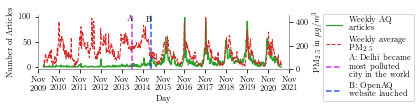

In [33]:
latexify(fig_width=4.5,fig_height=1)

fig,ax = plt.subplots()
plts = []

pm_color = "tab:red"
article_color = "tab:green"
#trend_color = "tab:green"

############################################################################################
city = "delhi"

start_date = datetime(2010,2,1)
end_date = datetime(2021,6,21)

df_articles["date"] = pd.to_datetime(df_articles["date"])
df_a = filter_cities(df_articles,[city])
print(len(df_a))
df_a = get_article_count_df(df_a,start_date=start_date,end_date=end_date)
#df_a = df_a.resample("7D",on="date").reset_index()

df_a = df_a.resample("7D",on="date").sum().reset_index()

x2 = df_a["date"]
y2 = df_a["count"]
    
twin = []

plt2 = ax.plot(x2,y2,label = "Weekly AQ\narticles",linewidth=1.2,color=article_color)
ax.set_ylabel("Number of Articles")
ax.set_xlabel("Day")

ax2 = ax.twinx()
twin.append(ax2)
format_axes(ax,twinx=True)
#ax.set_yticks(np.arange(0,111,55))
#format_axes(ax_t,twinx=True);


plts.append(plt2[0])
ax_t = ax2

#plot PM2.5 data
city_df = df_daily_city_merged[df_daily_city_merged.city == city]
city_df["From Date"] = pd.to_datetime(city_df["From Date"])

which_df = city_df
which_df = which_df[(which_df["From Date"] >= start_date) & (which_df["From Date"] <= end_date)]
which_df = which_df.resample("7D",on="From Date").mean().reset_index()
keyword = "PM2_5"

#total_count = which_df[keyword].sum()
x1, y1 = which_df["From Date"], which_df[keyword]

plt1 = ax_t.plot(x1,y1,"--",label = "Weekly average\nPM$_{2.5}$",color=pm_color,linewidth=1)
ax_t.set_ylabel("PM$_{2.5}$ in $\mu g/m^3$")
#ax_t.set_xlabel("Day")
#ax_t.set_title("Delhi")

plts.append(plt1[0])


#WHO updated database
openaq = datetime(2014,5,7)
indicator_2 = ax.axvline(x=openaq, linestyle='dashed', alpha=0.8,  color='#c300ff',label="A: Delhi became \nmost polluted \ncity in the world")
delta = pd.Timedelta(days=100)
#ax.annotate("New Delhi became\nmost polluted \ncity worldwise",xy = (openaq-delta,100))
ax.annotate("A",xy = (openaq-delta,90))
plts.append(indicator_2)


#OpenAQ lanch date
openaq = datetime(2015,4,1)
indicator_1 = ax.axvline(x=openaq, linestyle='dashed', alpha=0.8,  color='#0037ff',label="B: OpenAQ\nwebsite lauched")
delta = pd.Timedelta(days=100)
#ax.annotate("OpenAQ\nwebsite\nlauched",xy = (openaq+delta,100),)
ax.annotate("B",xy = (openaq-delta,90))
plts.append(indicator_1)



#set format of date
date_form = DateFormatter("%b\n%Y")


ax_t.xaxis.set_major_formatter(date_form)

#make interval of n months
ax_t.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax_t.tick_params(axis="x",rotation=0)
ax.set_xlim(datetime(2009,11,1),datetime(2021,11,1))


labs = [l.get_label() for l in plts] + [indicator_1.get_label()]
plt.legend(plts, labs, bbox_to_anchor=(1.12, 1.1))


format_axes(ax_t,twinx=True);


In [34]:
fig.savefig("../figures/fig4_timeseries_of_aq_articles_delhi_with_two_indicators.pdf",bbox_inches="tight")

## Plot of Number of cities available with time

In [32]:
air_pollutant = "PM2_5"

end_date = datetime(2021,6,21)
data = []
cities = df_daily_city_merged.city.unique()
#cities = igp_cities

#get top discussed cities
#cities_art = get_unique_cities_from_df(df_articles).nlargest(15,"articles")["city"]

#intersection of articles cities and pm2.5 availability cities
# cities_art = get_unique_cities_from_df(df_articles)["city"]
# cities_pm = df_daily_city_merged.city.unique()

# cities = set(cities_art).intersection(cities_pm)

not_found = []
print(len(cities),"cities")
for fname in cities:
    
    #df = pd.read_csv(all_cities_path+fname)
    fname = fname.lower()
    df = df_daily_city_merged[df_daily_city_merged.city == fname]
    
    
    try:
        df["From Date"] = pd.to_datetime(df["From Date"])
        
        start_date = get_start_date(fname)
        #start_date = datetime(2015,6,1)
        df = df[(df["From Date"]>=start_date) & (df["From Date"]<=end_date)] #subset
        #df = df[(df["From Date"]<=start_date) & (df["From Date"]>=end_date)] #strictly have start_date & end_date
        
        data.append({"city":df["city"].unique()[0],
                     "state":df["state"].unique()[0],

                    "PM2_5":int(round(df[air_pollutant].mean(),2)),
                    "start_date":df.dropna(subset=["PM2_5"])["From Date"].min().date(), #start date when first reading taken
                    "end_date":df.dropna(subset=["PM2_5"])["From Date"].max().date(), #end date when last reading taken
                    "active_days":len(df[~pd.isna(df[air_pollutant])])})
    except Exception as e:
        print(e)
        print(fname, "not found")
        not_found.append(fname)

df_avg_pm2_5 = pd.DataFrame(data)
df_avg_pm2_5.dropna(subset=["PM2_5"],inplace=True)
df_avg_pm2_5["address"] = df_avg_pm2_5.apply(lambda x:f"{x.city}, {x.state}",axis=1)
print(f"Before removing cities which have < 1year data- {len(df_avg_pm2_5)}")

df_avg_pm2_5 = df_avg_pm2_5[df_avg_pm2_5["active_days"]>365] #remove the cities which has data less than 1 year
df_avg_pm2_5

101 cities
agra
2015-05-11 00:00:00
ahmedabad
2017-09-26 00:00:00
ambala
Invalid comparison between dtype=datetime64[ns] and NoneType
ambala not found
ankleshwar
2019-05-01 00:00:00
bahadurgarh
Invalid comparison between dtype=datetime64[ns] and NoneType
bahadurgarh not found
ballabgarh
2019-04-30 00:00:00
bengaluru
2015-03-20 00:00:00
bhiwani
2019-04-30 00:00:00
chennai
2015-03-23 00:00:00
damoh
2018-12-12 00:00:00
delhi
2010-02-17 00:00:00
dharuhera
2019-04-30 00:00:00
faridabad
2015-05-20 00:00:00
fatehabad
Invalid comparison between dtype=datetime64[ns] and NoneType
fatehabad not found
gandhinagar
2019-05-01 00:00:00
ghaziabad
2017-10-01 00:00:00
gurugram
2016-01-22 00:00:00
guwahati
2019-04-30 00:00:00
hapur
2018-10-05 00:00:00
hisar
2019-04-30 00:00:00
hyderabad
2015-03-31 00:00:00
jind
2019-04-30 00:00:00
kaithal
2019-04-30 00:00:00
kanpur
2015-05-12 00:00:00
karnal
2019-04-30 00:00:00
kurukshetra
Invalid comparison between dtype=datetime64[ns] and NoneType
kurukshetra not found

,city,state,PM2_5,start_date,end_date,active_days,address
0,agra,Uttar Pradesh,103,2015-05-11,2021-06-21,2001,"agra, Uttar Pradesh"
1,ahmedabad,Gujarat,65,2017-09-26,2021-06-21,1183,"ahmedabad, Gujarat"
2,ankleshwar,NaN,57,2019-05-01,2021-06-08,536,"ankleshwar, nan"
3,ballabgarh,NaN,81,2019-04-30,2021-06-08,600,"ballabgarh, nan"
4,bengaluru,Karnataka,36,2015-03-20,2021-06-21,2123,"bengaluru, Karnataka"
...,...,...,...,...,...,...,...
91,muzaffarnagar,Uttar Pradesh,93,2018-06-25,2021-06-08,765,"muzaffarnagar, Uttar Pradesh"
92,patiala,Punjab,42,2018-02-06,2021-06-08,1021,"patiala, Punjab"
93,rupnagar,Punjab,67,2018-04-26,2021-03-24,843,"rupnagar, Punjab"
94,satna,Madhya Pradesh,24,2018-02-02,2021-06-08,1013,"satna, Madhya Pradesh"


## Plot of number of cities for which PM2.5 data is available

In [33]:
years = {}
for idx,row in df_avg_pm2_5.iterrows():
    y1 = row["start_date"].year
    y2 = row["end_date"].year
    for start_year in range(y1,y2):
        if start_year>2020:
            continue
        try:
            years[start_year+1] +=1
        except:
            years[start_year+1] = 1
years[2010] = 0
years

{2016: 17,
 2017: 23,
 2018: 48,
 2019: 72,
 2020: 87,
 2021: 86,
 2011: 1,
 2012: 2,
 2013: 2,
 2014: 2,
 2015: 5,
 2010: 0}

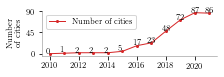

In [37]:
latexify(columns=1,fig_width=3,fig_height=1.1)

year_range = range(2010,2022,1)

count = [years[each] for each in year_range]
fig,ax = plt.subplots()
fig.tight_layout()

ax.plot(year_range,count,"-o",linewidth=1,markersize=2,color="tab:red",label="Number of cities")
for x,y in zip(year_range,count):
    ax.annotate(y,xy=(x-0.3,y+2))


format_axes(ax)
ax.set_yticks(np.arange(0,91,45))

ax.set(ylabel="Number\nof cities");
#ax.set_title("")
ax.legend()

plt.show()
